In [19]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]

# Resized image directories
resized_covid_folder = 'dataset/resized_images/COVID'
resized_lung_opacity_folder = 'dataset/resized_images/Lung_Opacity'
resized_normal_folder = 'dataset/resized_images/Normal'
resized_viral_pneumonia_folder = 'dataset/resized_images/Viral_Pneumonia'
resized_folders = [resized_covid_folder, resized_lung_opacity_folder, resized_normal_folder, resized_viral_pneumonia_folder]

# Directories to save the standardized images
standardized_covid_folder = 'dataset/standardized_images/COVID'
standardized_lung_opacity_folder = 'dataset/standardized_images/Lung_Opacity'
standardized_normal_folder = 'dataset/standardized_images/Normal'
standardized_viral_pneumonia_folder = 'dataset/standardized_images/Viral_Pneumonia'
standardized_folders = [standardized_covid_folder, standardized_lung_opacity_folder, standardized_normal_folder, standardized_viral_pneumonia_folder]

# Directories to save the featured images
featured_covid_folder = 'dataset/featured_images/COVID'
featured_lung_opacity_folder = 'dataset/featured_images/Lung_Opacity'
featured_normal_folder = 'dataset/featured_images/Normal'
featured_viral_pneumonia_folder = 'dataset/featured_images/Viral_Pneumonia'
featured_folders = [featured_covid_folder, featured_lung_opacity_folder, featured_normal_folder, featured_viral_pneumonia_folder]


In [21]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

# 1. DATA ANALYSIS

Image dimensions: (299, 299)


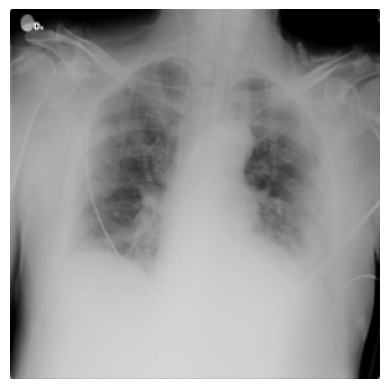

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [22]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 2. FEATURE ENGINEERING

Se toma una cantidad especifica de cada conjunto para que haya una similitud entre todos los conjuntos y se redimensionan a 128x128 

In [23]:
# Create directories if they don't exist
create_directories(resized_folders)

# Function to resize images and save them in the new directories
def resize_and_save_images(image_folder, resized_folder, samples):
    image_files = os.listdir(image_folder)
    image_files = image_files[:samples]  # Select the specified number of samples
    for file_name in image_files:
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (128, 128))  # Resize the image
        new_file_name = os.path.splitext(file_name)[0] + '_resized.png'  # New file name
        cv2.imwrite(os.path.join(resized_folder, new_file_name), resized_img)

# Resize images and save images
num_samples = [3616, 3700, 3700, 1345]
[resize_and_save_images(clean_folder, resized_folder, samples) for clean_folder, resized_folder, samples in zip(clean_folders, resized_folders, num_samples)]
print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")

STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.


Se estandarizan las imágenes después del redimensionamiento

Image dimensions: (128, 128)


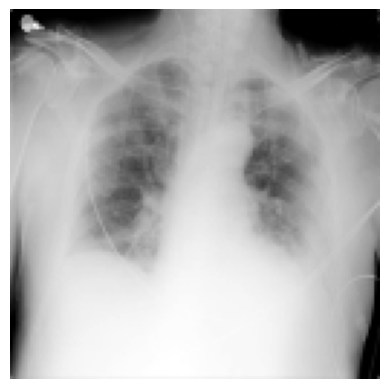

Number of images per class


In [24]:
# Show information
image = cv2.imread(resized_covid_folder+'/COVID-1_resized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=resized_folders, img=image)
# df

In [25]:
# Create directories if they don't exist
create_directories(standardized_folders)

# Function to standardize and save images to new directories
def standardize_and_save_images(resized_folder, standardized_folder):
    for filename in os.listdir(resized_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(resized_folder, filename)  # Path to the current image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
            image_float = image.astype("float32")  # Convert the image to a float32 NumPy array
            mean, std_dev = cv2.meanStdDev(image_float)  # Calculate mean and standard deviation
            standardized_mean = 127
            standardized_std_dev = 63
            standardized_image = (image_float - mean) / std_dev * standardized_std_dev + standardized_mean
            standardized_image_uint8 = standardized_image.astype("uint8")  # Convert image to uint8
            new_filename = os.path.splitext(filename)[0] + '_standardized.png'  # New file name
            cv2.imwrite(os.path.join(standardized_folder, new_filename), standardized_image_uint8)  # Save the standardized image

# Standardize and save images
[standardize_and_save_images(resized_folder, standardized_folder) for resized_folder, standardized_folder in zip(resized_folders, standardized_folders)]
print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")

STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (128, 128)


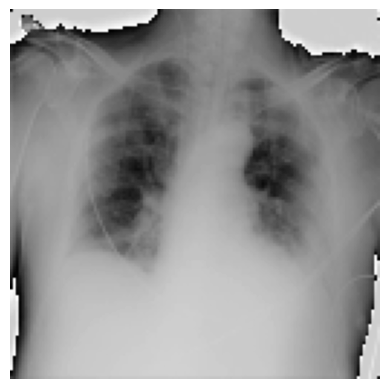

Number of images per class


In [26]:
# Show information
image = cv2.imread(standardized_covid_folder+'/COVID-1_resized_standardized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=standardized_folders, img=image)
# df

# 3. FEATURE EXTRACTOR

In [27]:
from skimage import feature

# Create directories if they don't exist
create_directories(featured_folders)

# Aplica el extractor de Histogramas de Color
def color_histograms(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    n = sum(hist.flatten())
    hist_normalized = hist.flatten() / n
    return hist_normalized

# Aplica Local Binary Patterns
radius = 1 # Radius of the circle used to calculate the patterns
points = 8 * radius # Number of sampling points on the circle
def local_binary_patterns(image):
    lbp = feature.local_binary_pattern(image, points, radius, method='uniform')
    # lbp_normalized = np.uint8((lbp / np.max(lbp)) * 255)
    lbp_normalized = cv2.normalize(lbp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return lbp_normalized

# Function to standardize and save images to new directories
def apply_feature_extractor(standardized_folder, featured_folder, filter):
    for filename in os.listdir(standardized_folder):
        image_path = os.path.join(standardized_folder, filename)   # Path to the current image        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
        
        # Applies the corresponding extractor according to the type of filter
        if   filter.lower() == "histo" : featured_image = color_histograms(image)
        elif filter.lower() == "lbp"   : featured_image = local_binary_patterns(image)
        else:
            print("Tipo de filtro no válido. Debe ser 'Histo' o 'LBP'.")
            continue
    
        # Save the result as an image in the output directory
        new_filename = os.path.splitext(filename)[0].replace("_resized_standardized", "") + '_featured.png'  # New file name
        cv2.imwrite(os.path.join(featured_folder, new_filename), featured_image) # Save the image

# Standardize and save images
feature_extractor = 'LBP'
[apply_feature_extractor(standardized_folder, featured_folder, filter=feature_extractor) for standardized_folder, featured_folder in zip(standardized_folders, featured_folders)]
print("FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.")

FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (128, 128)


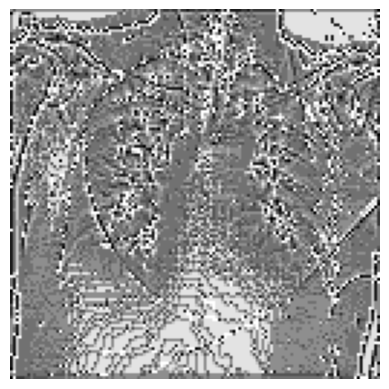

Number of images per class


In [28]:
# Show information
image = cv2.imread(featured_covid_folder+'/COVID-1_featured.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=featured_folders, img=image)
# df

# 4. TRAINING

Load the data of 'X' and 'y'

In [29]:
# Load lung images
covid_data = load_data(featured_covid_folder, 0)
lung_opacity_data = load_data(featured_lung_opacity_folder, 1)
normal_data = load_data(featured_normal_folder, 2)
viral_pneumonia_data = load_data(featured_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [30]:
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Check the dimensions of the training and test sets
pd.DataFrame({
    'Variable': ['X train', 'y train',  'X test', 'y test'],
    'Dimensions': [X_train.shape, y_train.shape, X_test.shape, y_test.shape],
}).style.hide().set_properties(**{'text-align': 'left'})


Variable,Dimensions
X train,"(9888, 16384)"
y train,"(9888, 4)"
X test,"(2473, 16384)"
y test,"(2473, 4)"


## Arquitectura 1

In [31]:
# Create the MLP model
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

# Train model
start = time.time()
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=1)
train_time = time.time() - start

# Evaluate model
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
results1 = [recall, accuracy, precision, train_time]

pd.DataFrame({
    'Metric': ['Recall', 'Accuracy', 'Precision', 'Training time'],
    'Scores': results1,
}).style.hide().set_properties(**{'text-align': 'left'})

Epoch 1/1000
309/309 [==============================] - 8s 26ms/step - loss: 198.8336 - accuracy: 0.3974 - recall: 0.3974 - precision: 0.3974 - val_loss: 22.9598 - val_accuracy: 0.6029 - val_recall: 0.6029 - val_precision: 0.6036
Epoch 2/1000
309/309 [==============================] - 10s 31ms/step - loss: 47.7005 - accuracy: 0.5430 - recall: 0.5430 - precision: 0.5430 - val_loss: 109.9080 - val_accuracy: 0.4391 - val_recall: 0.4391 - val_precision: 0.4391
Epoch 3/1000
309/309 [==============================] - 9s 28ms/step - loss: 24.1927 - accuracy: 0.6188 - recall: 0.6188 - precision: 0.6188 - val_loss: 21.1920 - val_accuracy: 0.5487 - val_recall: 0.5487 - val_precision: 0.5487
Epoch 4/1000
309/309 [==============================] - 9s 29ms/step - loss: 18.6956 - accuracy: 0.6612 - recall: 0.6612 - precision: 0.6613 - val_loss: 13.5894 - val_accuracy: 0.6405 - val_recall: 0.6405 - val_precision: 0.6405
Epoch 5/1000
309/309 [==============================] - 9s 29ms/step - loss: 20.3

Metric,Scores
Recall,0.000000
Accuracy,0.299232
Precision,0.000000
Training time,8347.665662


## Arquitectura 2

In [32]:
# Create the MLP model
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

# Train model
start = time.time()
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=1)
train_time = time.time() - start

# Evaluate model
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
results2 = [recall, accuracy, precision, train_time]

pd.DataFrame({
    'Metric': ['Recall', 'Accuracy', 'Precision', 'Training time'],
    'Scores': results2,
}).style.hide().set_properties(**{'text-align': 'left'})

Epoch 1/1000
309/309 [==============================] - 8s 23ms/step - loss: 1.3377 - accuracy: 0.2993 - recall: 0.0019 - precision: 0.3167 - val_loss: 1.3371 - val_accuracy: 0.2992 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/1000
309/309 [==============================] - 7s 22ms/step - loss: 1.3332 - accuracy: 0.2975 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3477 - val_accuracy: 0.2928 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/1000
309/309 [==============================] - 7s 23ms/step - loss: 1.3305 - accuracy: 0.2934 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3281 - val_accuracy: 0.2992 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/1000
309/309 [==============================] - 7s 22ms/step - loss: 1.3298 - accuracy: 0.2959 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3234 - val_accuracy: 0.2992 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/1000
309/309 [==============

Metric,Scores
Recall,0.000000
Accuracy,0.299232
Precision,0.000000
Training time,7195.491066


## Arquitectura 3

In [33]:
# Create the MLP model
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

# Train model
start = time.time()
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=1)
train_time = time.time() - start

# Evaluate model
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
results3 = [recall, accuracy, precision, train_time]

pd.DataFrame({
    'Metric': ['Recall', 'Accuracy', 'Precision', 'Training time'],
    'Scores': results3,
}).style.hide().set_properties(**{'text-align': 'left'})

Epoch 1/1000
309/309 [==============================] - 8s 23ms/step - loss: 1.3339 - accuracy: 0.2985 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3310 - val_accuracy: 0.2928 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/1000
309/309 [==============================] - 7s 23ms/step - loss: 1.3294 - accuracy: 0.2996 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3240 - val_accuracy: 0.2992 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/1000
309/309 [==============================] - 7s 23ms/step - loss: 1.3253 - accuracy: 0.3029 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3260 - val_accuracy: 0.2928 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/1000
309/309 [==============================] - 7s 23ms/step - loss: 1.3287 - accuracy: 0.2913 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.3262 - val_accuracy: 0.2928 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/1000
309/309 [======

Metric,Scores
Recall,0.000000
Accuracy,0.299232
Precision,0.000000
Training time,7137.391923


# Resultados

In [34]:
pd.DataFrame({
    'Metric': ['Recall', 'Accuracy', 'Precision', 'Training time'],
    'Arch 1': results1,
    'Arch 2': results2,
    'Arch 3': results3,
}).style.hide().set_properties(**{'text-align': 'left'})

Metric,Arch 1,Arch 2,Arch 3
Recall,0.000000,0.000000,0.000000
Accuracy,0.299232,0.299232,0.299232
Precision,0.000000,0.000000,0.000000
Training time,8347.665662,7195.491066,7137.391923
